In [16]:
import pandas as pd
import numpy as np
import json
import re
import math
import matplotlib.pyplot as plt
from langdetect import detect
from os import path
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [4]:
df = pd.read_csv('issues.csv')
# Fix value of labels column to make it a valid json object
df['labels'] = df['labels'].str.replace('"',"'")
df['labels'] = df['labels'].str.replace("None","'None'",regex=False)
df['labels'] = df['labels'].str.replace("{'",'{"',regex=False)
df['labels'] = df['labels'].str.replace("': '",'": "',regex=False)
df['labels'] = df['labels'].str.replace("', '",'", "',regex=False)
df['labels'] = df['labels'].str.replace("'}",'"}',regex=False)
df['labels'] = df['labels'].str.replace("': \"",'": "',regex=False)
df['labels'] = df['labels'].str.replace("\", '",'", "',regex=False)
df['labels'] = df['labels'].str.replace("\\",'\\\\',regex=False)
df['labels'] = df['labels'].str.lower()
labelled = df[df['labels'] != '[]']

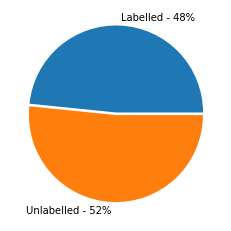

Total: 2262191
Labelled: 1094639


In [5]:
totalCount = len(df)
labelledCount = len(labelled)
unlabelledCount = totalCount - labelledCount
unlabelledPct = unlabelledCount / totalCount
labelledPct = labelledCount / totalCount


y = [labelledPct, unlabelledPct]
mylabels = ["Labelled - " + str(round(labelledPct*100)) + "%", "Unlabelled - " + str(round(unlabelledPct*100))+"%"]
myexplode = [0.03, 0]

plt.pie(y, labels = mylabels, explode = myexplode)
#plt.savefig("labelled_unlabelled_pi.png",dpi=1000)
plt.show()

print("Total: " +str(totalCount))
print("Labelled: "+str(labelledCount))

In [ ]:
#See how many unique labels are in our dataset
#unique_labels = {}
#for index, row in labelled.iterrows():
#    labelList = json.loads(row['labels'])
#    for label in labelList:
#        lbl_name = label['name:']
#        if lbl_name not in unique_labels:
#            unique_labels[lbl_name] = 1
#        else:
#            unique_labels[lbl_name]+=1
#sorted_label_dictionary = dict(sorted(unique_labels.items(), key=lambda item: item[1], reverse=True))

In [6]:
if (path.exists('labelledWithLang.csv') == False):
    language_col = []
    for index, row in labelled.iterrows():
        try:
            title_body_concat = ""
            if(pd.isnull(row['title']) ==False):
                title_body_concat = row['title']
            if (pd.isnull(row['body'])==False):
                title_body_concat = title_body_concat + " " + row['body']

            language_col.append(detect(title_body_concat))
        except Exception as e:
            language_col.append('')
    labelled['language'] = language_col
else:
    labelled = pd.read_csv('labelledWithLang.csv')

In [7]:
english_labelled = labelled[labelled['language'] == 'en']
english_labelled['title_body_concat'] = english_labelled['body'].astype(str) + english_labelled['title']

In [8]:
english_labelled['enhancement'] = np.where(english_labelled['labels'].str.contains('enhancement'), 1, 0)
english_labelled['bug'] = np.where(english_labelled['labels'].str.contains('bug'), 1, 0)
english_labelled['feature'] = np.where(english_labelled['labels'].str.contains('feature'), 1, 0)

In [9]:
train, test = train_test_split(english_labelled, random_state=42, test_size=0.33, shuffle=True)
X_train = train.title_body_concat
X_test = test.title_body_concat


categories = ['enhancement', 'bug', 'feature']

In [10]:
print("* Creating a naive bayes model")
naiveBayesModel = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
nb_predictions = {}
for category in categories:
    print('Training {}'.format(category))
    naiveBayesModel.fit(X_train, train[category])
    nb_predictions[category] = naiveBayesModel.predict(X_test)

Creating a naive bayes model
Training enhancement
Training bug
Training feature


In [12]:
print("* Creating a logistic regression based model")
logisticRegressionModel = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
logistic_predictions = {}
for category in categories:
    print('Training {}'.format(category))
    logisticRegressionModel.fit(X_train, train[category])
    logistic_predictions[category] = logisticRegressionModel.predict(X_test)

* Creating a logistic regression based model
Training enhancement
Training bug
Training feature


In [13]:
print("* Creating a linear svc model")
linearSVCModel = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
svc_predictions = {}
for category in categories:
    print('Training {}'.format(category))
    linearSVCModel.fit(X_train, train[category])
    svc_predictions[category] = linearSVCModel.predict(X_test)

* Creating a linear svc model
Training enhancement
Training bug
Training feature


*** Category: enhancement
- Accuracy
 Naive Bayes: 0.78877344038729
 Logistic Regression: 0.814965172669644
 Linear SVC: 0.8257956401655462
*** Category: bug
- Accuracy
 Naive Bayes: 0.771000076171561
 Logistic Regression: 0.837495027689773
 Linear SVC: 0.8502946710940211
*** Category: feature
- Accuracy
 Naive Bayes: 0.7971212792308365
 Logistic Regression: 0.8296324299010052
 Linear SVC: 0.8431486502117287


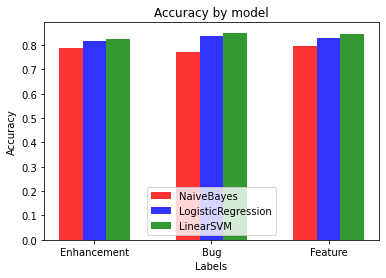

In [18]:
n_groups = 3
naive_bayes = []
logistic_regression = []
linear_svc = []
for category in categories:
    naive_bayes.append(accuracy_score(test[category], nb_predictions[category]))
    logistic_regression.append(accuracy_score(test[category], logistic_predictions[category]))
    linear_svc.append(accuracy_score(test[category], svc_predictions[category]))
    print("*** Category: {}".format(category))
    print("- Accuracy")
    print(" Naive Bayes: {}".format(str(naive_bayes[len(naive_bayes)-1])))
    print(" Logistic Regression: {}".format(str(logistic_regression[len(logistic_regression)-1])))
    print(" Linear SVC: {}".format(str(linear_svc[len(linear_svc)-1])))
    

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

plt.bar(index, naive_bayes, bar_width, alpha=opacity, color='r', label='NaiveBayes')
plt.bar(index + bar_width, logistic_regression, bar_width, alpha=opacity, color='b', label='LogisticRegression')
plt.bar(index + 2*bar_width, linear_svc, bar_width, alpha=opacity, color='g', label='LinearSVM')
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy by model')
plt.xticks(index + bar_width, ('Enhancement', 'Bug', 'Feature'))
plt.legend()
plt.savefig("bar_comparison.png",dpi=1000)
#plt.show()